# ==============================>
# 1. Imports and Configs
# ==============================>

In [2]:
import json
import os

import kagglehub as kh
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from bs4 import BeautifulSoup
from scipy import stats

C:\Cryp2Real\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# ==============================>
# 2. Download and Database Read
# ==============================>

In [3]:
path = kh.dataset_download("fronkongames/steam-games-dataset")
json_path = os.path.join(path, 'games.json')

with open(json_path, 'r', encoding='utf-8') as f:
    dataset = json.load(f)

# ==============================>
# 3. DataFrame Conversion
# ==============================>

In [4]:
games_list = []
for app_id, game in dataset.items():

    price = game.get('price', 0)
    try:
        # alguns preços vêm como 'Free' ou strings tipo '0.0'
        price = float(price) if price not in ["Free", ""] else 0.0
    except (ValueError, TypeError):
        price = 0.0

    # === Trata MetacriticScore (converte string para número ou NaN) ===
    meta = game.get('metacritic_score')
    try:
        meta = float(meta)
    except (ValueError, TypeError):
        meta = np.nan

    # === Monta o dicionário principal ===
    game_data = {
        'AppID': app_id,
        'Name': game.get('name', ''),
        'RequiredAge': int(game.get('required_age', 0) or 0),
        'ReleaseDate': game.get('release_date', ''),
        'Price': price,
        'MetacriticScore': meta,
        'DlcCount': int(game.get('dlc_count', 0) or 0),
        'DetailedDescription': game.get('detailed_description', ''),
        'AboutTheGame': game.get('about_the_game', ''),
        'Reviews': game.get('reviews', ''),
        'HeaderImage': game.get('header_image', ''),
        'Website': game.get('website', ''),
        'Achievements': int(game.get('achievements', 0) or 0),
        'Recommendations': int(game.get('recommendations', 0) or 0),
        'Notes': game.get('notes', ''),
        'SupportedLanguages': game.get('supported_languages', ''),
        'Developers': game.get('developers', ''),
        'Publishers': game.get('publishers', ''),
        'EstimatedOwners': game.get('estimated_owners', ''),
        'Positive': int(game.get('positive', 0) or 0),
        'Negative': int(game.get('negative', 0) or 0),
        'PeakCCU': int(game.get('peak_ccu', 0) or 0),
        'AveragePlaytimeForever': int(game.get('average_playtime_forever', 0) or 0),
        'AveragePlaytime2Weeks': int(game.get('average_playtime_2weeks', 0) or 0),
        'MedianPlaytimeForever': int(game.get('median_playtime_forever', 0) or 0),
        'MedianPlaytime2Weeks': int(game.get('median_playtime_2weeks', 0) or 0),
        'Genres': ', '.join(game.get('genres', [])) if isinstance(game.get('genres'), list) else '',
        'Categories': ', '.join(game.get('categories', [])) if isinstance(game.get('categories'), list) else '',
        'Screenshots': len(game.get('screenshots', [])) if isinstance(game.get('screenshots'), list) else 0,
        'Movies': len(game.get('movies', [])) if isinstance(game.get('movies'), list) else 0
    }

    games_list.append(game_data)

df = pd.DataFrame(games_list)
print(f"📊 DataFrame: {df.shape[0]} lines and {df.shape[1]} columns")

📊 DataFrame: 111452 lines and 30 columns


# ==============================>
# 4. Save CSV
# ==============================>

In [5]:
df.to_csv("steam_games.csv", encoding="utf-8", index=False)

# ==============================>

# 5. Questions

# ==============================>


# Question 1 : What kind of correlation exists between Price and MetaScore?

In [10]:
# ==================================================================================================
# Question 1: What kind of correlation exists between Price and MetaScore?
# ==================================================================================================

# Columns to show in the interactive plot
cols_to_keep = ['Price', 'MetacriticScore', 'Name', 'Developers', 'Publishers']

# Remove null values from Price and MetacriticScore
df_corr = df[cols_to_keep].dropna(subset=['Price', 'MetacriticScore'])
df_corr = df_corr[(df_corr['Price'] > 0) & (df_corr['MetacriticScore'] > 0)]

# ============================================
# Statistical Analysis (Correlation)
# ============================================

# Pearson Correlation (Linear)
pearson_corr, pearson_pval = stats.pearsonr(df_corr['Price'], df_corr['MetacriticScore'])

print(f"1. PEARSON CORRELATION (Price vs Metacritic Score):")

print("\n" + "="*60)
print("QUICK INTERPRETATION")
print("="*60)
print(f"Pearson's r ({pearson_corr:.3f}) indicates a very weak linear correlation.")
print(f"Price explains only {(pearson_corr**2)*100:.2f}% of the variation in Metacritic scores.")
print("="*60)


# ============================================
# Visualization 1: Price vs Metacritic Rating (Colored by Price Range)
# ============================================

# Create price range categories
def categorize_price(price):
    if price < 10:
        return '$0-10 (Budget)'
    elif price < 20:
        return '$10-20 (Low)'
    elif price < 40:
        return '$20-40 (Mid)'
    elif price < 60:
        return '$40-60 (Premium)'
    else:
        return '$60+ (AAA)'

# Add price category column
df_corr['PriceCategory'] = df_corr['Price'].apply(categorize_price)

# Define color mapping for each price range
color_map = {
    '$0-10 (Budget)': '#00ff00',      # Green
    '$10-20 (Low)': '#ffff00',        # Yellow
    '$20-40 (Mid)': '#ff0000',        # Red
    '$40-60 (Premium)': '#ff8c00',    # Orange
    '$60+ (AAA)': '#8b00ff'           # Purple
}

# Create scatter plot with colors by price range
fig1 = px.scatter(
    df_corr,
    x='Price',
    y='MetacriticScore',
    title='Price vs. Metacritic Rating (Colored by Price Range)',
    color='PriceCategory',
    color_discrete_map=color_map,
    hover_data={
        'Name': True,
        'Developers': True,
        'Publishers': True,
        'Price': ':.2f',
        'MetacriticScore': True,
        'PriceCategory': False
    },
    category_orders={
        'PriceCategory': [
            '$0-10 (Budget)',
            '$10-20 (Low)',
            '$20-40 (Mid)',
            '$40-60 (Premium)',
            '$60+ (AAA)'
        ]
    }
)

# Update layout for better appearance
fig1.update_layout(
    xaxis_title="Price (USD)",
    yaxis_title="Metacritic Score",
    legend_title="Price Range",
    font=dict(size=12),
    hovermode='closest',
    plot_bgcolor='rgba(240, 240, 240, 0.5)',
    showlegend=True
)

# Update marker size and opacity
fig1.update_traces(
    marker=dict(
        size=8,
        opacity=0.7,
        line=dict(width=0.5, color='white')
    )
)

fig1.show()

# Print statistics by price range
print("\n" + "="*60)
print("STATISTICS BY PRICE RANGE")
print("="*60)
for category in ['$0-10 (Budget)', '$10-20 (Low)', '$20-40 (Mid)', '$40-60 (Premium)', '$60+ (AAA)']:
    subset = df_corr[df_corr['PriceCategory'] == category]
    if len(subset) > 0:
        print(f"\n{category}:")
        print(f"  Games: {len(subset)}")
        print(f"  Avg Metacritic: {subset['MetacriticScore'].mean():.2f}")
        print(f"  Avg Price: ${subset['Price'].mean():.2f}")


# ============================================
# Visualization 2: Price vs Metacritic Rating (Colored by Review Quality)
# ============================================

# Create score quality categories
def categorize_score(score):
    if score >= 80:
        return 'Excellent (80-100)'
    elif score >= 60:
        return 'Good (60-79)'
    elif score >= 40:
        return 'Mixed (40-59)'
    elif score >= 20:
        return 'Poor (20-39)'
    else:
        return 'Bad (0-19)'

# Add score category column
df_corr['ScoreCategory'] = df_corr['MetacriticScore'].apply(categorize_score)

# Define color mapping for each score range
score_color_map = {
    'Excellent (80-100)': '#00ff00',  # Green - Excellent games
    'Good (60-79)': '#9acd32',        # Yellow-Green - Good games
    'Mixed (40-59)': '#ffa500',       # Orange - Mixed reviews
    'Poor (20-39)': '#ff4500',        # Orange-Red - Poor games
    'Bad (0-19)': '#ff0000'           # Red - Bad games
}

# Create scatter plot with colors by score quality
fig2 = px.scatter(
    df_corr,
    x='Price',
    y='MetacriticScore',
    title='Price vs. Metacritic Rating (Colored by Review Quality)',
    color='ScoreCategory',
    color_discrete_map=score_color_map,
    hover_data={
        'Name': True,
        'Developers': True,
        'Publishers': True,
        'Price': ':.2f',
        'MetacriticScore': True,
        'ScoreCategory': False
    },
    category_orders={
        'ScoreCategory': [
            'Excellent (80-100)',
            'Good (60-79)',
            'Mixed (40-59)',
            'Poor (20-39)',
            'Bad (0-19)'
        ]
    }
)

# Update layout for better appearance
fig2.update_layout(
    xaxis_title="Price (USD)",
    yaxis_title="Metacritic Score",
    legend_title="Review Quality",
    font=dict(size=12),
    hovermode='closest',
    plot_bgcolor='rgba(240, 240, 240, 0.5)',
    showlegend=True
)

# Update marker size and opacity
fig2.update_traces(
    marker=dict(
        size=8,
        opacity=0.7,
        line=dict(width=0.5, color='white')
    )
)

fig2.show()

# Print statistics by score quality
print("\n" + "="*60)
print("STATISTICS BY REVIEW QUALITY")
print("="*60)
for category in ['Excellent (80-100)', 'Good (60-79)', 'Mixed (40-59)', 'Poor (20-39)', 'Bad (0-19)']:
    subset = df_corr[df_corr['ScoreCategory'] == category]
    if len(subset) > 0:
        print(f"\n{category}:")
        print(f"  Games: {len(subset)}")
        print(f"  Avg Price: ${subset['Price'].mean():.2f}")
        print(f"  Avg Metacritic: {subset['MetacriticScore'].mean():.2f}")

# End of Question 1
# ==================================================================================================


1. PEARSON CORRELATION (Price vs Metacritic Score):

QUICK INTERPRETATION
Pearson's r (0.235) indicates a very weak linear correlation.
Price explains only 5.51% of the variation in Metacritic scores.



STATISTICS BY PRICE RANGE

$0-10 (Budget):
  Games: 1552
  Avg Metacritic: 70.79
  Avg Price: $7.30

$10-20 (Low):
  Games: 1446
  Avg Metacritic: 73.73
  Avg Price: $17.23

$20-40 (Mid):
  Games: 561
  Avg Metacritic: 75.90
  Avg Price: $30.47

$40-60 (Premium):
  Games: 129
  Avg Metacritic: 79.81
  Avg Price: $55.77

$60+ (AAA):
  Games: 7
  Avg Metacritic: 83.71
  Avg Price: $69.99



STATISTICS BY REVIEW QUALITY

Excellent (80-100):
  Games: 1093
  Avg Price: $19.94
  Avg Metacritic: 83.93

Good (60-79):
  Games: 2210
  Avg Price: $15.59
  Avg Metacritic: 71.46

Mixed (40-59):
  Games: 365
  Avg Price: $12.14
  Avg Metacritic: 53.08

Poor (20-39):
  Games: 27
  Avg Price: $11.90
  Avg Metacritic: 33.89


# Question 2 : What kind of correlation exists between Price and RequiredAge?


2. PEARSON CORRELATION (Price vs RequiredAge):

QUICK INTERPRETATION
Pearson's r (0.175) indicates a weak linear correlation.
Price explains only 3.06% of the variation in Required Age ratings.


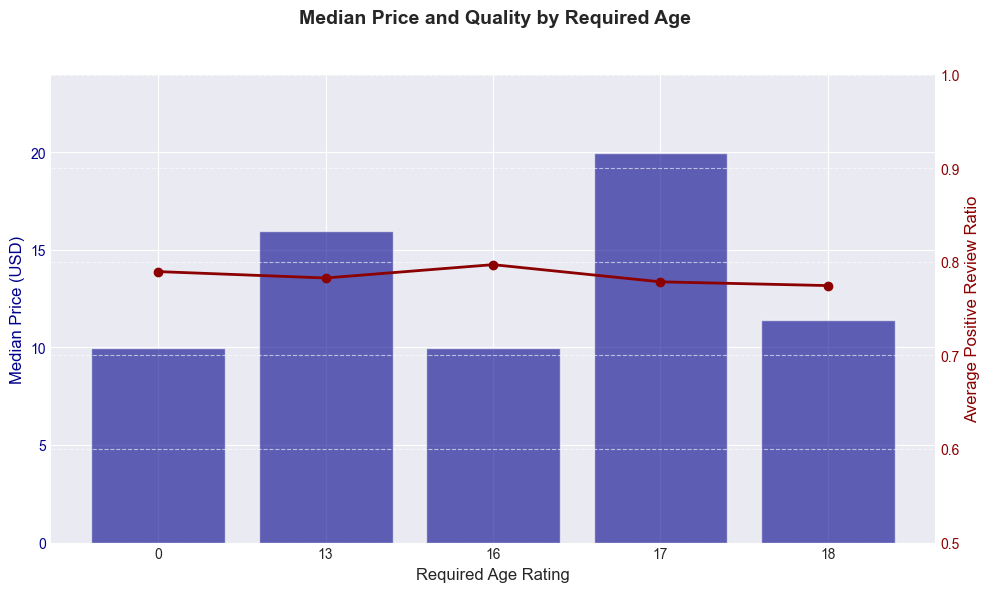

In [11]:
# Ensure essential columns for ReviewRatio exist
df['TotalReviews'] = df['Positive'] + df['Negative']
# Calculate Review Ratio (Positive reviews / Total reviews), np.nan if false
df['ReviewRatio'] = np.where(df['TotalReviews'] > 0, df['Positive'] / df['TotalReviews'], np.nan)

# Filter out games with no age rating or insufficient reviews for relevance
df_filtered = df[(df['RequiredAge'] >= 0) & (df['TotalReviews'] > 100)].copy()

# ===================================================
# STATISTICAL ANALYSIS: Pearson Correlation
# ===================================================

pearson_corr_age, pearson_pval_age = stats.pearsonr(df_filtered['Price'], df_filtered['RequiredAge'])

print()
print(f"2. PEARSON CORRELATION (Price vs RequiredAge):")

print("\n" + "="*60)
print("QUICK INTERPRETATION")
print("="*60)
if abs(pearson_corr_age) < 0.1:
    strength = "very weak"
elif abs(pearson_corr_age) < 0.3:
    strength = "weak"
elif abs(pearson_corr_age) < 0.5:
    strength = "moderate"
else:
    strength = "strong"

print(f"Pearson's r ({pearson_corr_age:.3f}) indicates a {strength} linear correlation.")
print(f"Price explains only {(pearson_corr_age**2)*100:.2f}% of the variation in Required Age ratings.")
print("="*60)

# ===================================================
# DATA AGGREGATION FOR VISUALIZATION
# ===================================================

df_filtered['RequiredAge'] = df_filtered['RequiredAge'].astype('category')

# --- 1. Simple Grouping by Required Age ---
age_analysis = df_filtered.groupby('RequiredAge', observed=True).agg( # Agregate
    # Median Price (less sensitive to price outliers than mean)
    MedianPrice=('Price', 'median'),
    # Mean of Positive Review Ratio
    AverageReviewRatio=('ReviewRatio', 'mean'),
    GameCount=('AppID', 'count')
).reset_index() # Index begin with 0

# Filter out groups with too few games for robust analysis
min_games_per_age = 20
age_analysis = age_analysis[age_analysis['GameCount'] >= min_games_per_age]

# ===================================================
# VISUALIZATION (Twin Axes)
# ===================================================

fig, ax1 = plt.subplots(figsize=(10, 6))

# Axis 1: Median Price (Bars)
color_price = 'darkblue'
ax1.set_xlabel('Required Age Rating', fontsize=12)
ax1.set_ylabel('Median Price (USD)', color=color_price, fontsize=12)
ax1.bar(
    age_analysis['RequiredAge'].astype(str),
    age_analysis['MedianPrice'],
    color=color_price,
    alpha=0.6,
    label='Median Price'
)
ax1.tick_params(axis='y', labelcolor=color_price)
ax1.set_ylim(0, age_analysis['MedianPrice'].max() * 1.2)

# Axis 2: Average Positive Review Ratio (Line Plot)
ax2 = ax1.twinx()
# Creates a second Y-axis (ax2) that shares the same X-axis (ax1).
# This allows plotting two metrics (Price and Review Ratio) with different scales on the same chart.

color_ratio = 'darkred'
# Defines the color 'darkred' for the elements of this secondary axis,
# ensuring visual contrast with the primary axis (Price, which is 'darkblue').

ax2.set_ylabel('Average Positive Review Ratio', color=color_ratio, fontsize=12)
# Sets the label for the second Y-axis (on the right) to 'Average Positive Review Ratio'
# and applies the defined color ('darkred') and font size.

ax2.plot(
# Starts plotting a line on the secondary axis (ax2).
    age_analysis['RequiredAge'].astype(str),
    # Defines the data for the X-axis: the required age groups (converted to strings).
    age_analysis['AverageReviewRatio'],
    # Defines the data for the Y-axis: the average positive review ratio values.
    color=color_ratio,
    # Applies the 'darkred' color to the line.
    marker='o',
    # Adds a circle marker ('o') at each data point on the line.
    linestyle='-',
    # Sets the line style to solid ('-').
    linewidth=2,
    # Sets the thickness of the line to 2 pixels.
    label='Average Review Ratio'
    # Defines the label for this line, which will be used in the legend.
)

ax2.tick_params(axis='y', labelcolor=color_ratio)
# Applies the 'darkred' color to the tick labels (values) on the secondary Y-axis,
# visually linking the numbers to the data line.

ax2.set_ylim(0.5, 1.0)
# Sets the limits for the secondary Y-axis from 0.5 (50%) to 1.0 (100%),
# focusing on the most relevant range for positive review ratios.

fig.suptitle('Median Price and Quality by Required Age', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout(rect=(0.0, 0.0, 1.0, 0.96))
plt.show()

# End of Question 2

# ==================================================================================================

# Question 3 : Correlation between Positive Reviews and Recommendations


3. PEARSON CORRELATION (Positive Review vs Recommendations):

QUICK INTERPRETATION (Positive Reviews vs. Recommendations)
1. PEARSON COEFFICIENT (r): 0.8973
2. INTERPRETATION: Strong positive linear correlation.
3. R-SQUARED: Positive Reviews explain 80.51% of the variation in Recommendations.


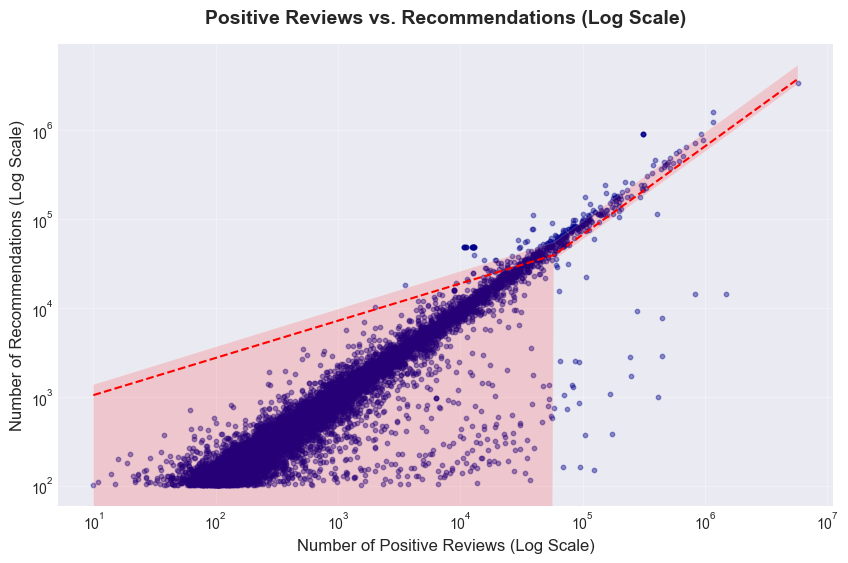

In [12]:
# --- 1. Data Filtering for Correlation ---
cols_corr_recommend = ['Positive', 'Recommendations', 'Name']
df_corr_recommend = df[cols_corr_recommend].copy() # Keep 2 different dataframes

# Drop rows with missing values in either column to ensure valid correlation
# The parameter 'inplace=True' modifies the original DataFrame directly,
# without creating a new copy. If set to False (default), the method returns
# a modified copy instead, leaving the original DataFrame unchanged.
df_corr_recommend.dropna(subset=['Positive', 'Recommendations'], inplace=True)

# Keep only rows where both values are positive (avoid zeros or negatives that distort correlation)
df_corr_recommend = df_corr_recommend[
    (df_corr_recommend['Positive'] > 0) &
    (df_corr_recommend['Recommendations'] > 0)
]

# --- 2. Statistical Analysis (Pearson Correlation) ---
# Pearson requires at least 2 valid data points
if df_corr_recommend.shape[0] >= 2:

    # Compute Pearson correlation coefficient and p-value
    pearson_corr_recommend, pearson_pval_recommend = stats.pearsonr(
        df_corr_recommend['Positive'],
        df_corr_recommend['Recommendations']
    )

    # --- 3. Interpretation ---
    # Coefficient of determination (r^2), representing the % of explained variation
    r_squared = (pearson_corr_recommend ** 2) * 100

    # Define correlation strength based on absolute value of r
    correlation_strength = 'Very Weak'
    if abs(pearson_corr_recommend) >= 0.5:
        correlation_strength = 'Strong'
    elif abs(pearson_corr_recommend) >= 0.3:
        correlation_strength = 'Moderate'
    elif abs(pearson_corr_recommend) > 0.1:
        correlation_strength = 'Weak'

    # Determine direction (positive or negative correlation)
    direction = 'positive' if pearson_corr_recommend > 0 else 'negative'

    print()
    print(f"3. PEARSON CORRELATION (Positive Review vs Recommendations):")

    # Print formatted summary
    print("\n" + "=" * 60)
    print("QUICK INTERPRETATION (Positive Reviews vs. Recommendations)")
    print("=" * 60)
    print(f"1. PEARSON COEFFICIENT (r): {pearson_corr_recommend:.4f}")
    print(f"2. INTERPRETATION: {correlation_strength} {direction} linear correlation.")
    print(f"3. R-SQUARED: Positive Reviews explain {r_squared:.2f}% of the variation in Recommendations.")
    print("=" * 60)

    # --- 4. Visualization (Scatter Plot) ---
    fig, ax = plt.subplots(figsize=(10, 6))

    # Scatter plot showing relationship between Positive Reviews and Recommendations
    ax.scatter(
        df_corr_recommend['Positive'],
        df_corr_recommend['Recommendations'],
        alpha=0.4,     # transparency for better readability
        s=10,          # marker size
        color='darkblue'
    )

    # Use logarithmic scales to handle large numeric ranges
    ax.set_xscale('log')
    ax.set_yscale('log')

    # Add linear regression trendline (in red, dashed)

    sns.regplot(  # Create a regression plot (scatter + regression linear fit)
        x='Positive',  # Column on the x-axis represents number of positive reviews
        y='Recommendations',  # Column on the y-axis represents number of recommendations
        data=df_corr_recommend,  # DataFrame containing the columns to plot
        scatter=False,  # Disable scatter points (no need)
        color='red',  # Color of the regression line
        line_kws={  # Keyword arguments for line styling
            'linestyle': '--',  # Dashed line style for visual distinction
            'linewidth': 1.5,  # Slightly thicker line for better visibility
            'label': f"Linear Trend (r={pearson_corr_recommend:.2f})"  # Add label with Pearson's r value
        },
        ax=ax  # Plot on the existing matplotlib Axes object
    )

    # Configure plot titles and labels
    ax.set_title('Positive Reviews vs. Recommendations (Log Scale)', fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel('Number of Positive Reviews (Log Scale)', fontsize=12)
    ax.set_ylabel('Number of Recommendations (Log Scale)', fontsize=12)

    plt.grid(True, alpha=0.3)
    plt.show()

# End of Question 3

# ==================================================================================================

# Question 4 : Which genres are the most profitable (median price) and which have the best engagement (playtime)?

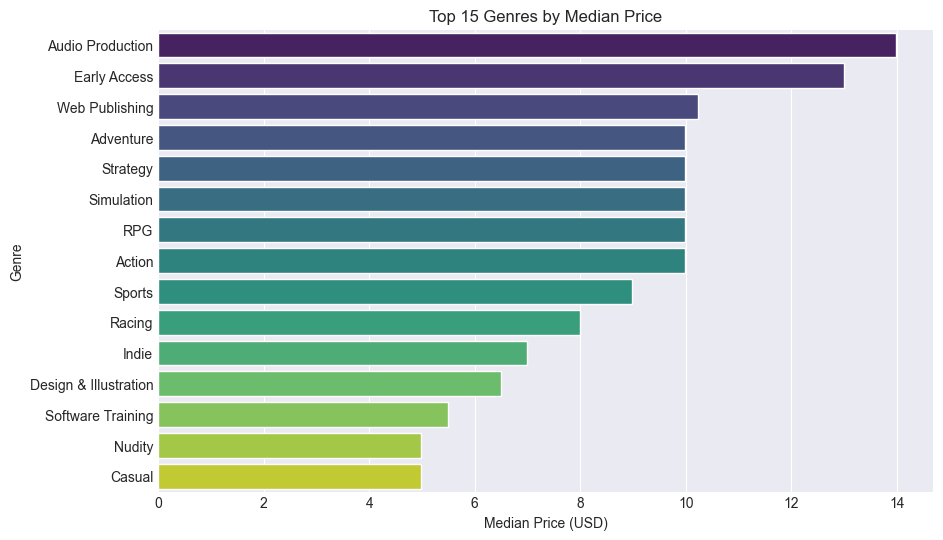

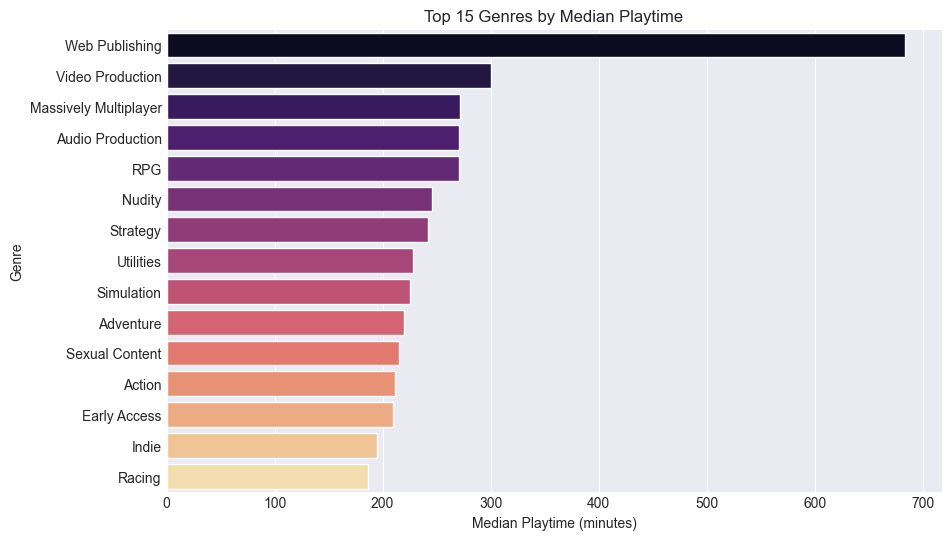


Observation:
- Genres with higher median price tend to be strategy or simulation games.
- Genres with longer playtime usually include RPGs and sandbox games.
- Engagement (playtime) is not necessarily tied to higher prices.



In [14]:
df_genres = df[['Genres', 'Price', 'AveragePlaytimeForever']].dropna()
df_genres = df_genres[df_genres['AveragePlaytimeForever'] > 0]  # <--- nova linha
df_genres['Genres'] = df_genres['Genres'].str.split(', ')
df_genres = df_genres.explode('Genres')

# by genre
genre_stats = df_genres.groupby('Genres').agg(
    MedianPrice=('Price', 'median'),
    MedianPlaytime=('AveragePlaytimeForever', 'median'),
    Count=('Genres', 'count')
).reset_index()

# only genres with enough games to be relevant
genre_stats = genre_stats[genre_stats['Count'] >= 20]

# median price by genre
plt.figure(figsize=(10,6))
top_price = genre_stats.sort_values('MedianPrice', ascending=False).head(15)
sns.barplot(y='Genres',
            x='MedianPrice',
            data=top_price,
            hue='Genres',          # Adiciona hue = Genres
            palette='viridis',
            legend=False)          # Remove legenda duplicada
plt.title('Top 15 Genres by Median Price')
plt.xlabel('Median Price (USD)')
plt.ylabel('Genre')
plt.show()

# median playtime by genre
plt.figure(figsize=(10,6))
top_playtime = genre_stats.sort_values('MedianPlaytime', ascending=False).head(15)
sns.barplot(y='Genres',
    x='MedianPlaytime',
    data=top_playtime,
    hue='Genres', # semantic color
    palette='magma',
    legend=False)
plt.title('Top 15 Genres by Median Playtime')
plt.xlabel('Median Playtime (minutes)')
plt.ylabel('Genre')
plt.show()

print("""
Observation:
- Genres with higher median price tend to be strategy or simulation games.
- Genres with longer playtime usually include RPGs and sandbox games.
- Engagement (playtime) is not necessarily tied to higher prices.
""")

# Question 5 : How does time since release affect number of recommendations / reviews?

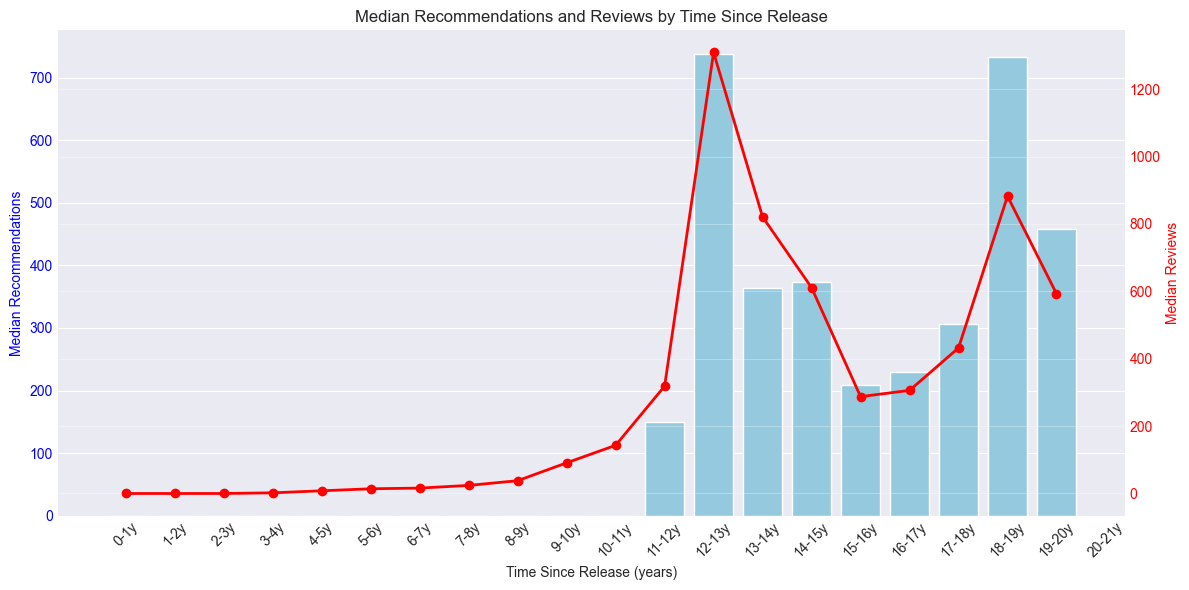


Observation:
- Older games accumulate more recommendations and reviews.
- Very recent games have low numbers, independent of quality.
- Using medians per release-year bin smooths the extreme disparities and shows trend clearly.



In [16]:
# Ensure TotalReviews exists
df['TotalReviews'] = df['Positive'] + df['Negative']

# Convert ReleaseDate to datetime
df['ReleaseDate'] = pd.to_datetime(df['ReleaseDate'], errors='coerce')

# Calculate days since release
df['DaysSinceRelease'] = (pd.Timestamp('today') - df['ReleaseDate']).dt.days

# Drop rows with missing values
df_time = df[['DaysSinceRelease', 'Recommendations', 'TotalReviews']].dropna()

# Create bins for days since release (intervals de 1 ano = 365 dias)
max_days = int(df_time['DaysSinceRelease'].max())
bins = list(range(0, max_days + 365, 365))

labels = [f"{i}-{i+1}y" for i in range(len(bins)-1)]
df_time['ReleaseBin'] = pd.cut(df_time['DaysSinceRelease'], bins=bins, labels=labels, right=False)

# Aggregate medians by bin
time_stats = df_time.groupby('ReleaseBin', observed = False).agg( # observed = False to avoid deprecated 'error'
    MedianRecommendations=('Recommendations', 'median'),
    MedianReviews=('TotalReviews', 'median'),
    Count=('DaysSinceRelease', 'count')
).reset_index()

# Only keep bins with enough games
time_stats = time_stats[time_stats['Count'] >= 20]

# ==============================
# Visualization: Median Recommendations and Reviews by Time Since Release
# ==============================

fig, ax1 = plt.subplots(figsize=(12,6))

# Bar plot for Median Recommendations
sns.barplot(x='ReleaseBin', y='MedianRecommendations', data=time_stats, color='skyblue', ax=ax1)
ax1.set_xlabel('Time Since Release (years)')
ax1.set_ylabel('Median Recommendations', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.tick_params(axis='x', rotation=45)

# Line plot for Median Reviews
ax2 = ax1.twinx()
ax2.plot(time_stats['ReleaseBin'], time_stats['MedianReviews'], color='red', marker='o', linewidth=2, label='Median Reviews')
ax2.set_ylabel('Median Reviews', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Median Recommendations and Reviews by Time Since Release')
plt.grid(True, alpha=0.3)
plt.tight_layout()
#fig.savefig('question5_median_Recommendations_by_Time_Since_Release.png', dpi=300, bbox_inches='tight')
plt.show()


print("""
Observation:
- Older games accumulate more recommendations and reviews.
- Very recent games have low numbers, independent of quality.
- Using medians per release-year bin smooths the extreme disparities and shows trend clearly.
""")

# Question 6: Which are the Top Languages?

In [18]:
top_languages = ['English', 'Chinese', 'Spanish', 'French', 'German', 'Russian', 'Portuguese', 'Japanese']

df['TotalReviews'] = df['Positive'].fillna(0) + df['Negative'].fillna(0)


for lang in top_languages:
    df[f'Supports_{lang}'] = (
        df['SupportedLanguages']
        .astype(str)
        .str.lower()
        .str.contains(lang.lower(), na=False)
    )


# group median adn count
lang_stats = []
for lang in top_languages:
    mask = df[f'Supports_{lang}']
    lang_stats.append({
        'Language': lang,
        'MedianPrice': df.loc[mask, 'Price'].median(),
        'MedianReviews': df.loc[mask, 'TotalReviews'].median(),
        'MedianRecommendations': df.loc[mask, 'Recommendations'].median(),
        'Count': mask.sum()
    })

lang_summary = pd.DataFrame(lang_stats)
lang_summary = lang_summary[lang_summary['Count'] >= 50]  # at least 50 games

# plot

fig = px.scatter(
    lang_summary,
    x='MedianPrice',
    y='MedianReviews',
    size='Count',  # number games
    color='MedianReviews',
    hover_name='Language',
    hover_data={
        'MedianPrice': True,
        'MedianReviews': True,
        'Count': True
    },
    color_continuous_scale='Viridis',
    size_max=60,
    title='Median Reviews vs Median Price by Language\n(Bubble Size ~ Number of Games, Color ~ Median Reviews)',
    labels={
        'MedianPrice': 'Median Price (USD)',
        'MedianReviews': 'Median Reviews',
        'Count': 'Number of Games'
    }
)

fig.update_layout(
    xaxis=dict(showgrid=True, gridcolor='lightgrey'),
    yaxis=dict(showgrid=True, gridcolor='lightgrey'),
    legend_title_text='Median Reviews / Number of Games',
    template='plotly_white'
)

fig.show()

print("""
Observations:
- Games supporting English dominate both median price and median reviews, indicating that reaching a global audience is a critical factor.
- Other widely spoken languages, such as Chinese, Spanish, and French, show moderate engagement, suggesting more niche player bases.
- A clear trend appears where multilingual support correlates with higher median prices and stronger user engagement, highlighting the importance of language accessibility in game popularity.
- Bubble sizes represent the number of games per language, and color intensity indicates median recommendations, providing a comprehensive interactive view of language impact on sales and engagement.
""")


Observations:
- Games supporting English dominate both median price and median reviews, indicating that reaching a global audience is a critical factor.
- Other widely spoken languages, such as Chinese, Spanish, and French, show moderate engagement, suggesting more niche player bases.
- A clear trend appears where multilingual support correlates with higher median prices and stronger user engagement, highlighting the importance of language accessibility in game popularity.
- Bubble sizes represent the number of games per language, and color intensity indicates median recommendations, providing a comprehensive interactive view of language impact on sales and engagement.



# Question 7: Do games with achievements have better engagement and player retention?


Games WITH Achievements:
  Median Playtime: 227.00
  Avg Recommendations: 1,316.96
  Avg Review Ratio: 0.80

Games WITHOUT Achievements:
  Median Playtime: 151.00
  Avg Recommendations: 423.70
  Avg Review Ratio: 0.72


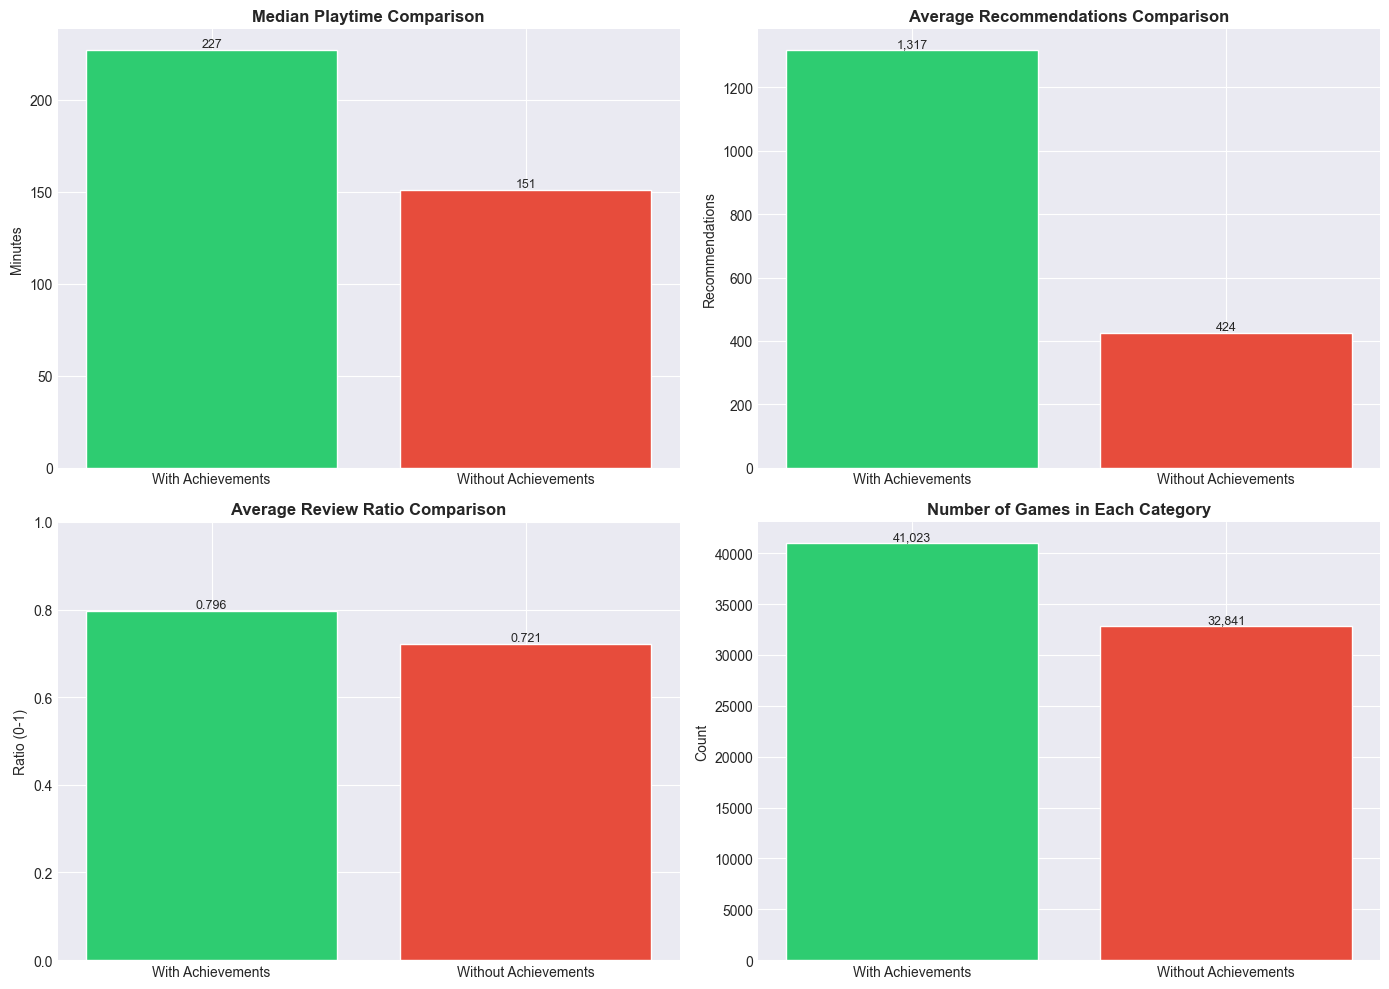

In [24]:
# Filter games with and without achievements
with_ach = df[df['Achievements'] > 0].copy()
without_ach = df[df['Achievements'] == 0].copy()

# Calculate Review Ratio for both groups
with_ach['ReviewRatio'] = with_ach['Positive'] / (with_ach['Positive'] + with_ach['Negative'])
without_ach['ReviewRatio'] = without_ach['Positive'] / (without_ach['Positive'] + without_ach['Negative'])

# Remove games with no reviews (but keep games with 0 playtime for now)
with_ach = with_ach.replace([np.inf, -np.inf], np.nan).dropna(subset=['ReviewRatio'])
without_ach = without_ach.replace([np.inf, -np.inf], np.nan).dropna(subset=['ReviewRatio'])

# Filter only games with playtime > 0 for meaningful comparison
with_ach_playtime = with_ach[with_ach['MedianPlaytimeForever'] > 0]
without_ach_playtime = without_ach[without_ach['MedianPlaytimeForever'] > 0]

# Calculate engagement metrics
metrics_with = {
    'Median Playtime': with_ach_playtime['MedianPlaytimeForever'].median(),
    'Avg Recommendations': with_ach['Recommendations'].mean(),
    'Avg Review Ratio': with_ach['ReviewRatio'].mean()
}

metrics_without = {
    'Median Playtime': without_ach_playtime['MedianPlaytimeForever'].median(),
    'Avg Recommendations': without_ach['Recommendations'].mean(),
    'Avg Review Ratio': without_ach['ReviewRatio'].mean()
}

print("\nGames WITH Achievements:")
for key, value in metrics_with.items():
    print(f"  {key}: {value:,.2f}")

print("\nGames WITHOUT Achievements:")
for key, value in metrics_without.items():
    print(f"  {key}: {value:,.2f}")

# ------ Bar Charts ------
categories = ['With Achievements', 'Without Achievements']
colors = ['#2ecc71', '#e74c3c']

plt.figure(figsize=(14, 10))

# 1. Median Playtime
plt.subplot(2, 2, 1)
playtime_values = [metrics_with['Median Playtime'], metrics_without['Median Playtime']]
bars1 = plt.bar(categories, playtime_values, color=colors)
plt.title('Median Playtime Comparison', fontsize=12, fontweight='bold')
plt.ylabel('Minutes', fontsize=10)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height, f'{height:,.0f}', ha='center', va='bottom', fontsize=9)

# 2. Average Recommendations
plt.subplot(2, 2, 2)
rec_values = [metrics_with['Avg Recommendations'], metrics_without['Avg Recommendations']]
bars2 = plt.bar(categories, rec_values, color=colors)
plt.title('Average Recommendations Comparison', fontsize=12, fontweight='bold')
plt.ylabel('Recommendations', fontsize=10)

for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height, f'{height:,.0f}', ha='center', va='bottom', fontsize=9)

# 3. Average Review Ratio
plt.subplot(2, 2, 3)
ratio_values = [metrics_with['Avg Review Ratio'], metrics_without['Avg Review Ratio']]
bars3 = plt.bar(categories, ratio_values, color=colors)
plt.title('Average Review Ratio Comparison', fontsize=12, fontweight='bold')
plt.ylabel('Ratio (0-1)', fontsize=10)
plt.ylim(0, 1)

for bar in bars3:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height, f'{height:.3f}',  ha='center', va='bottom', fontsize=9)

# 4. Number of Games
plt.subplot(2, 2, 4)
count_values = [len(with_ach), len(without_ach)]
bars4 = plt.bar(categories, count_values, color=colors)
plt.title('Number of Games in Each Category', fontsize=12, fontweight='bold')
plt.ylabel('Count', fontsize=10)

for bar in bars4:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,f'{int(height):,}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
#plt.savefig('question7_achievements_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# ==================================================================================================

# Question 8: Is it worth investing in DLCs? Do they really increase game lifespan and revenue?


Games WITH DLCs:
  Median Playtime: 255.00
  Avg Price: 12.86
  Avg Estimated Owners: 332,132.56
  Avg Review Ratio: 0.80

Games WITHOUT DLCs:
  Median Playtime: 186.00
  Avg Price: 7.35
  Avg Estimated Owners: 59,404.77
  Avg Review Ratio: 0.76


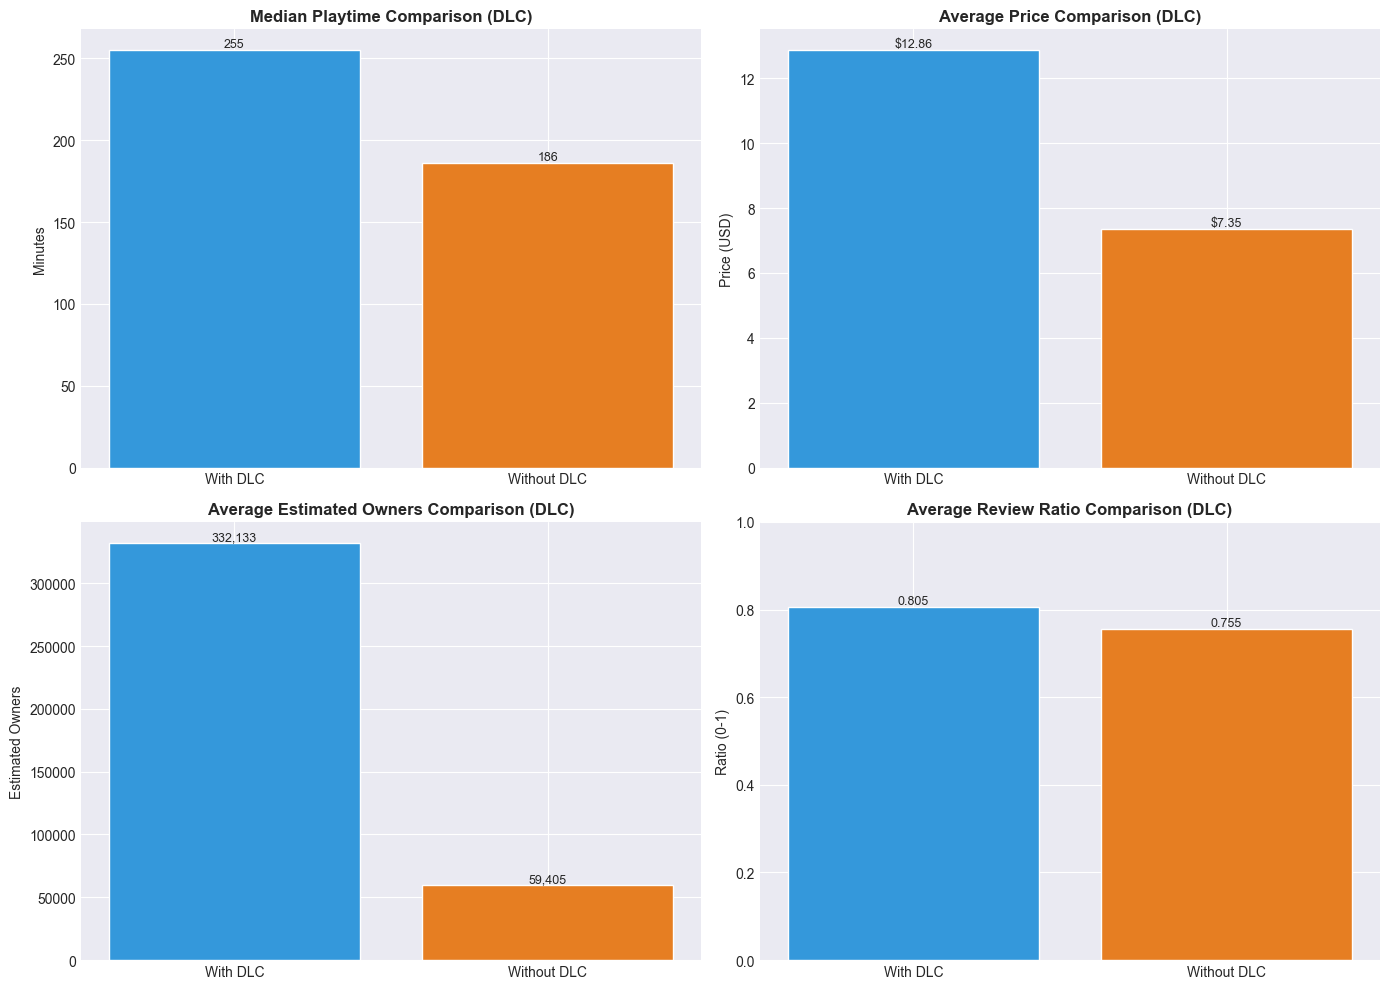

In [23]:
# Convert owners to numeric
def owners_to_number(owners):
    if type(owners) != str or '-' not in owners:
        return np.nan

    parts = owners.replace(',', '').split('-')
    return (int(parts[0]) + int(parts[1])) / 2

# Segment games by DLC presence
with_dlc = df[df['DlcCount'] > 0].copy()
without_dlc = df[df['DlcCount'] == 0].copy()

with_dlc['EstimatedOwnersNumeric'] = with_dlc['EstimatedOwners'].apply(owners_to_number)
without_dlc['EstimatedOwnersNumeric'] = without_dlc['EstimatedOwners'].apply(owners_to_number)

# Calculate Review Ratio
with_dlc['ReviewRatio'] = with_dlc['Positive'] / (with_dlc['Positive'] + with_dlc['Negative'])
without_dlc['ReviewRatio'] = without_dlc['Positive'] / (without_dlc['Positive'] + without_dlc['Negative'])

# Clean data
with_dlc = with_dlc.replace([np.inf, -np.inf], np.nan).dropna(subset=['ReviewRatio', 'EstimatedOwnersNumeric'])
without_dlc = without_dlc.replace([np.inf, -np.inf], np.nan).dropna(subset=['ReviewRatio', 'EstimatedOwnersNumeric'])

# Filter games with playtime > 0 for meaningful comparison
with_dlc_playtime = with_dlc[with_dlc['MedianPlaytimeForever'] > 0]
without_dlc_playtime = without_dlc[without_dlc['MedianPlaytimeForever'] > 0]

# Calculate metrics
metrics_with_dlc = {
    'Median Playtime': with_dlc_playtime['MedianPlaytimeForever'].median(),
    'Avg Price': with_dlc['Price'].mean(),
    'Avg Estimated Owners': with_dlc['EstimatedOwnersNumeric'].mean(),
    'Avg Review Ratio': with_dlc['ReviewRatio'].mean()
}

metrics_without_dlc = {
    'Median Playtime': without_dlc_playtime['MedianPlaytimeForever'].median(),
    'Avg Price': without_dlc['Price'].mean(),
    'Avg Estimated Owners': without_dlc['EstimatedOwnersNumeric'].mean(),
    'Avg Review Ratio': without_dlc['ReviewRatio'].mean()
}

print("\nGames WITH DLCs:")
for key, value in metrics_with_dlc.items():
    print(f"  {key}: {value:,.2f}")

print("\nGames WITHOUT DLCs:")
for key, value in metrics_without_dlc.items():
    print(f"  {key}: {value:,.2f}")

# ------ Bar Charts ------
categories_dlc = ['With DLC', 'Without DLC']
colors_dlc = ['#3498db', '#e67e22']

plt.figure(figsize=(14, 10))

# 1. Median Playtime
plt.subplot(2, 2, 1)
playtime_values_dlc = [metrics_with_dlc['Median Playtime'], metrics_without_dlc['Median Playtime']]
bars1 = plt.bar(categories_dlc, playtime_values_dlc, color=colors_dlc)
plt.title('Median Playtime Comparison (DLC)', fontsize=12, fontweight='bold')
plt.ylabel('Minutes', fontsize=10)

for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height, f'{height:,.0f}', ha='center', va='bottom', fontsize=9)

# 2. Average Price
plt.subplot(2, 2, 2)
price_values = [metrics_with_dlc['Avg Price'], metrics_without_dlc['Avg Price']]
bars2 = plt.bar(categories_dlc, price_values, color=colors_dlc)
plt.title('Average Price Comparison (DLC)', fontsize=12, fontweight='bold')
plt.ylabel('Price (USD)', fontsize=10)

for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height, f'${height:,.2f}', ha='center', va='bottom', fontsize=9)

# 3. Average Estimated Owners
plt.subplot(2, 2, 3)
owners_values = [metrics_with_dlc['Avg Estimated Owners'], metrics_without_dlc['Avg Estimated Owners']]
bars3 = plt.bar(categories_dlc, owners_values, color=colors_dlc)
plt.title('Average Estimated Owners Comparison (DLC)', fontsize=12, fontweight='bold')
plt.ylabel('Estimated Owners', fontsize=10)

for bar in bars3:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,f'{height:,.0f}', ha='center', va='bottom', fontsize=9)

# 4. Average Review Ratio
plt.subplot(2, 2, 4)
ratio_values_dlc = [metrics_with_dlc['Avg Review Ratio'], metrics_without_dlc['Avg Review Ratio']]
bars4 = plt.bar(categories_dlc, ratio_values_dlc, color=colors_dlc)
plt.title('Average Review Ratio Comparison (DLC)', fontsize=12, fontweight='bold')
plt.ylabel('Ratio (0-1)', fontsize=10)
plt.ylim(0, 1)

for bar in bars4:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('question8_dlc_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# ==================================================================================================

# Question 9: What price range maximizes the relationship between player satisfaction and sales volume?
# Which price should I put in my indie game?


Metrics by price range:
  PriceRange  ReviewRatio  EstimatedOwnersNumeric  Recommendations
0       $0-5     0.754774            36411.558724       155.271207
1      $5-10     0.782657            66229.855072       571.693449
2     $10-20     0.792496           120869.531311      1673.426733
3     $20-40     0.774367           279288.793103      4218.356609
4       $40+     0.738324           467190.831557      7326.557569


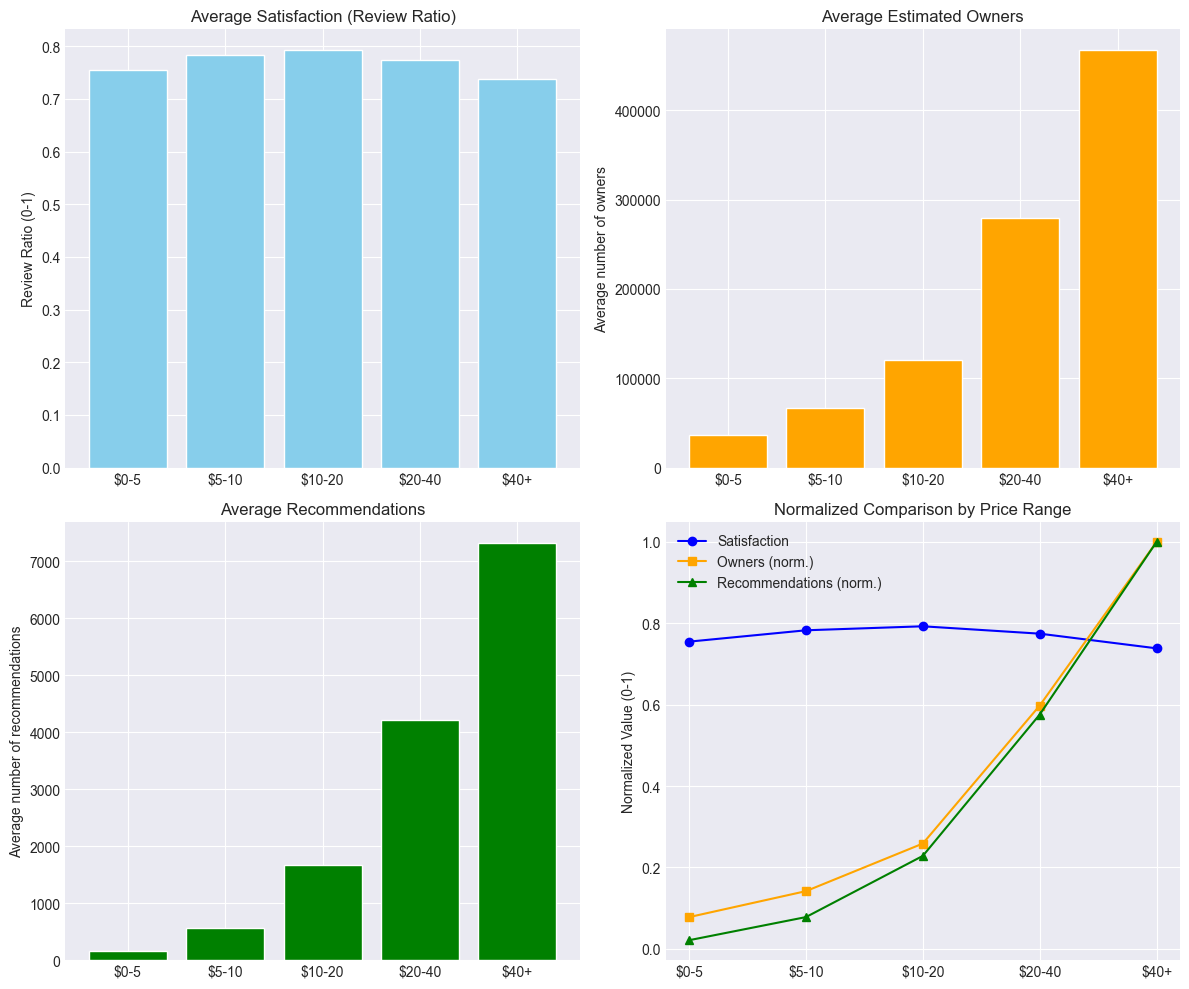


Ideal price range: $40+
  Review Ratio: 0.738
  Average owners: 467,191
  Average recommendations: 7,327


In [22]:
# Convert EstimatedOwners to numeric
df["EstimatedOwnersNumeric"] = df["EstimatedOwners"].apply(owners_to_number)

# Ensure necessary columns exist
df["ReviewRatio"] = df["Positive"] / (df["Positive"] + df["Negative"])
df["ReviewRatio"] = df["ReviewRatio"].replace([np.inf, -np.inf], np.nan)

# Create price ranges
df["PriceRange"] = pd.cut(df["Price"], bins=[0, 5, 10, 20, 40, float("inf")], labels=["$0-5", "$5-10", "$10-20", "$20-40", "$40+"])

# Filter only valid data
valid_data = df.dropna(subset=["ReviewRatio", "EstimatedOwnersNumeric", "Recommendations", "PriceRange"])

# Calculate averages by price range
stats = valid_data.groupby("PriceRange", observed=True).agg({
    "ReviewRatio": "mean",
    "EstimatedOwnersNumeric": "mean",
    "Recommendations": "mean"
}).reset_index()

print("\nMetrics by price range:")
print(stats)

# --- Bar charts (4 subplots) ---
plt.figure(figsize=(12, 10))

# 1. Average Review Ratio
plt.subplot(2, 2, 1)
plt.bar(stats["PriceRange"], stats["ReviewRatio"], color="skyblue")
plt.title("Average Satisfaction (Review Ratio)")
plt.ylabel("Review Ratio (0-1)")

# 2. Average estimated owners
plt.subplot(2, 2, 2)
plt.bar(stats["PriceRange"], stats["EstimatedOwnersNumeric"], color="orange")
plt.title("Average Estimated Owners")
plt.ylabel("Average number of owners")

# 3. Average recommendations
plt.subplot(2, 2, 3)
plt.bar(stats["PriceRange"], stats["Recommendations"], color="green")
plt.title("Average Recommendations")
plt.ylabel("Average number of recommendations")

# 4. Normalized comparison of three metrics
stats_norm = stats.copy()
stats_norm["OwnersNorm"] = stats["EstimatedOwnersNumeric"] / stats["EstimatedOwnersNumeric"].max()
stats_norm["RecsNorm"] = stats["Recommendations"] / stats["Recommendations"].max()

plt.subplot(2, 2, 4)
plt.plot(stats["PriceRange"], stats["ReviewRatio"], marker="o", label="Satisfaction", color="blue")
plt.plot(stats["PriceRange"], stats_norm["OwnersNorm"], marker="s", label="Owners (norm.)", color="orange")
plt.plot(stats["PriceRange"], stats_norm["RecsNorm"], marker="^", label="Recommendations (norm.)", color="green")
plt.title("Normalized Comparison by Price Range")
plt.ylabel("Normalized Value (0-1)")
plt.legend()

plt.tight_layout()
# plt.savefig('question9_') todo
plt.show()

# Determine the ideal range (sweet spot)
stats["BalanceScore"] = (
        stats["ReviewRatio"] * 0.4 +
        (stats["EstimatedOwnersNumeric"] / stats["EstimatedOwnersNumeric"].max()) * 0.3 +
        (stats["Recommendations"] / stats["Recommendations"].max()) * 0.3
)

best_range = stats.loc[stats["BalanceScore"].idxmax()]

print(f"\nIdeal price range: {best_range['PriceRange']}")
print(f"  Review Ratio: {best_range['ReviewRatio']:.3f}")
print(f"  Average owners: {best_range['EstimatedOwnersNumeric']:,.0f}")
print(f"  Average recommendations: {best_range['Recommendations']:,.0f}")

# Question 10: Which supported languages generate greater global reach without compromising ratings?